# Traffic Volume Prediction Using Time Series Models

This notebook implements time series models for predicting metro interstate traffic volume based on historical data and weather conditions. We'll perform a comparative analysis of three models:

1. **ARIMA** (AutoRegressive Integrated Moving Average) - Statistical approach for linear time series modeling
2. **LSTM** (Long Short-Term Memory) - Deep learning approach for capturing complex non-linear dependencies
3. **Hybrid Model** (ARIMA + LSTM) - Combination approach leveraging strengths of both models

## Dataset

Metro Interstate Traffic Volume Dataset from Kaggle, including hourly traffic volume for a specific metro interstate, along with weather and holiday information.

## 1. Setup and Data Loading

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For ARIMA modeling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For LSTM modeling
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# For evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set plotting style
sns.set(style="whitegrid")
plt.style.use('fivethirtyeight')
%matplotlib inline

# Configure plot size
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
# Check if TensorFlow is available
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Load the dataset
data = pd.read_csv('/content/Metro_Interstate_Traffic_Volume.csv')

# Display the first few rows
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


## 2. Data Preprocessing

In [4]:
# Data type information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [5]:
# Convert date_time to datetime format
data['date_time'] = pd.to_datetime(data['date_time'])

# Set date_time as index
data.set_index('date_time', inplace=True)

# Sort by datetime index
data.sort_index(inplace=True)

### 2.1 Missing Values Analysis and Handling

In [6]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()
missing_percent = (data.isnull().sum() / len(data)) * 100

# Create a DataFrame to display missing values
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percent
})

print("Missing Values Analysis:")
display(missing_df)

Missing Values Analysis:


,Missing Values,Percentage (%)
holiday,48143,99.873454
temp,0,0.000000
rain_1h,0,0.000000
snow_1h,0,0.000000
clouds_all,0,0.000000
weather_main,0,0.000000
weather_description,0,0.000000
traffic_volume,0,0.000000


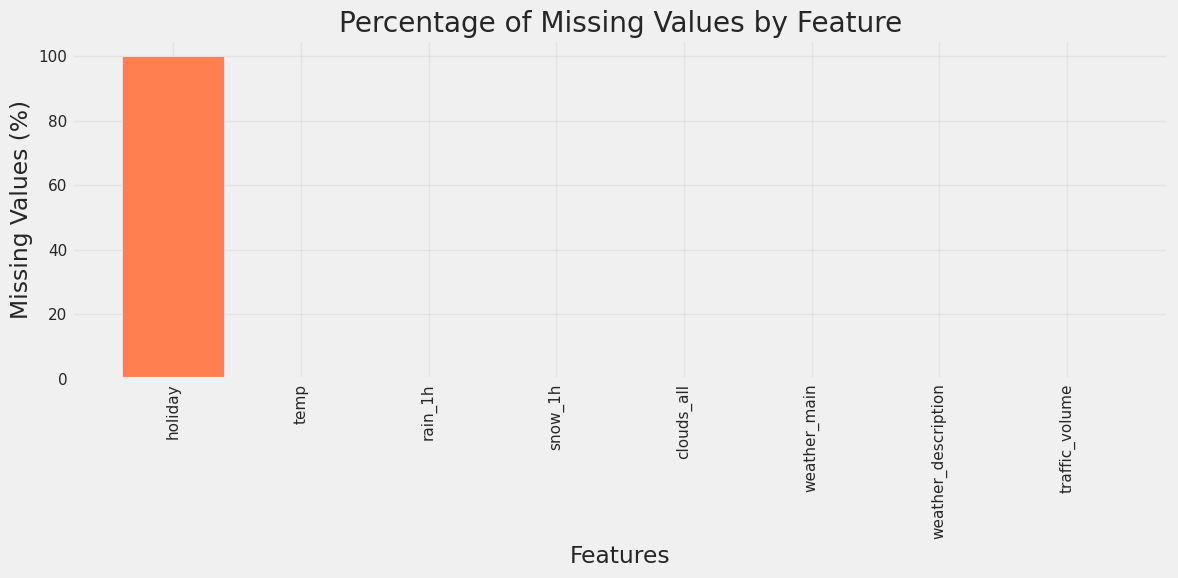

In [7]:
# Visualize missing values
plt.figure(figsize=(12, 6))
plt.bar(missing_df.index, missing_df['Percentage (%)'], color='coral')
plt.title('Percentage of Missing Values by Feature')
plt.xlabel('Features')
plt.ylabel('Missing Values (%)')
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# Handle missing values
print("\nMissing Value Handling Strategy:")
print("1. Drop 'holiday' column")
print("2. Numerical weather features: Use forward fill and then backward fill")
print("3. Categorical weather features: Mode imputation followed by forward fill")

# Drop 'holiday' column as requested
if 'holiday' in data.columns:
    data = data.drop(columns=['holiday'])
    print("Holiday column dropped from the dataset")

# Handle numerical weather columns
numerical_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all']
for col in numerical_cols:
    if data[col].isnull().sum() > 0:
        # First forward fill
        data[col] = data[col].fillna(method='ffill')
        # Then backward fill for any remaining NaNs at the beginning
        data[col] = data[col].fillna(method='bfill')

# Handle categorical weather columns
categorical_cols = ['weather_main', 'weather_description']
for col in categorical_cols:
    if data[col].isnull().sum() > 0:
        # Fill with mode (most common value)
        mode_value = data[col].mode()[0]
        data[col] = data[col].fillna(mode_value)
        # Apply forward fill for any consecutive missing values
        data[col] = data[col].fillna(method='ffill')

# Check if all missing values are handled
missing_after = data.isnull().sum().sum()
print(f"\nRemaining missing values after handling: {missing_after}")
print(f"\nUpdated dataset columns: {data.columns.tolist()}")


Missing Value Handling Strategy:
1. Drop 'holiday' column
2. Numerical weather features: Use forward fill and then backward fill
3. Categorical weather features: Mode imputation followed by forward fill
Holiday column dropped from the dataset

Remaining missing values after handling: 0

Updated dataset columns: ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description', 'traffic_volume']


In [9]:
# Feature engineering
# Extract hour, day of week, weekday/weekend
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Define peak hours (7-9 AM and 4-6 PM on weekdays)
data['is_peak_morning'] = ((data['hour'] >= 7) & (data['hour'] <= 9) & (data['is_weekend'] == 0)).astype(int)
data['is_peak_evening'] = ((data['hour'] >= 16) & (data['hour'] <= 18) & (data['is_weekend'] == 0)).astype(int)
data['is_peak_hour'] = ((data['is_peak_morning'] == 1) | (data['is_peak_evening'] == 1)).astype(int)

# Convert temperature from Kelvin to Celsius
data['temp_celsius'] = data['temp'] - 273.15

# Create month and year features
data['month'] = data.index.month
data['year'] = data.index.year

# Display processed data
data.head()

,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,hour,day_of_week,is_weekend,is_peak_morning,is_peak_evening,is_peak_hour,temp_celsius,month,year
date_time,,,,,,,,,,,,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,9,1,0,1,0,1,15.13,10,2012
2012-10-02 10:00:00,289.36,0.0,0.0,75,Clouds,broken clouds,4516,10,1,0,0,0,0,16.21,10,2012
2012-10-02 11:00:00,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,11,1,0,0,0,0,16.43,10,2012
2012-10-02 12:00:00,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,12,1,0,0,0,0,16.98,10,2012
2012-10-02 13:00:00,291.14,0.0,0.0,75,Clouds,broken clouds,4918,13,1,0,0,0,0,17.99,10,2012


In [10]:
# Create hourly aggregated data for time series modeling
data_hourly = data['traffic_volume'].resample('h').mean()

# Check for missing values in hourly aggregated data
print(f"Missing values in hourly data: {data_hourly.isnull().sum()}")

# Handle missing values in hourly data
if data_hourly.isnull().sum() > 0:
    # Linear interpolation for short gaps
    data_hourly_interpolated = data_hourly.interpolate(method='linear', limit=3)

    # Forward fill for remaining gaps
    data_hourly = data_hourly_interpolated.ffill()

    # Backward fill for any remaining gaps at the beginning
    data_hourly = data_hourly.bfill()

    print(f"Missing values after handling: {data_hourly.isnull().sum()}")

# Display hourly data
data_hourly.head()

Missing values in hourly data: 11976
Missing values after handling: 0


,traffic_volume
date_time,
2012-10-02 09:00:00,5545.0
2012-10-02 10:00:00,4516.0
2012-10-02 11:00:00,4767.0
2012-10-02 12:00:00,5026.0
2012-10-02 13:00:00,4918.0


## 3. Exploratory Data Analysis (EDA)

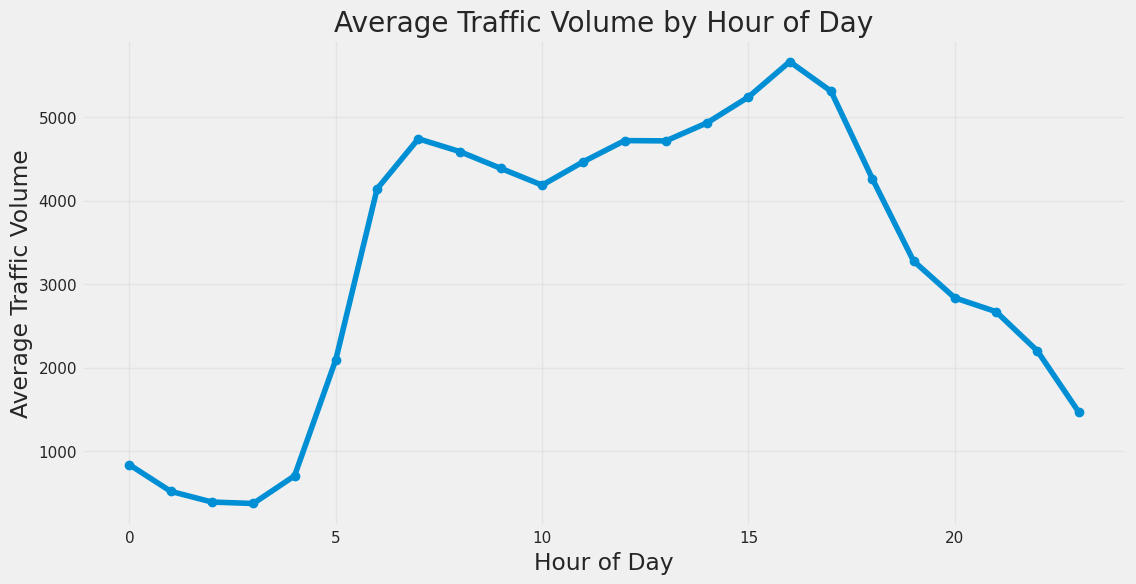

In [11]:
# Hourly traffic patterns
hourly_avg = data.groupby('hour')['traffic_volume'].mean()
plt.figure(figsize=(12, 6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linestyle='-')
plt.title('Average Traffic Volume by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Volume')
plt.grid(True, alpha=0.3)
plt.show()

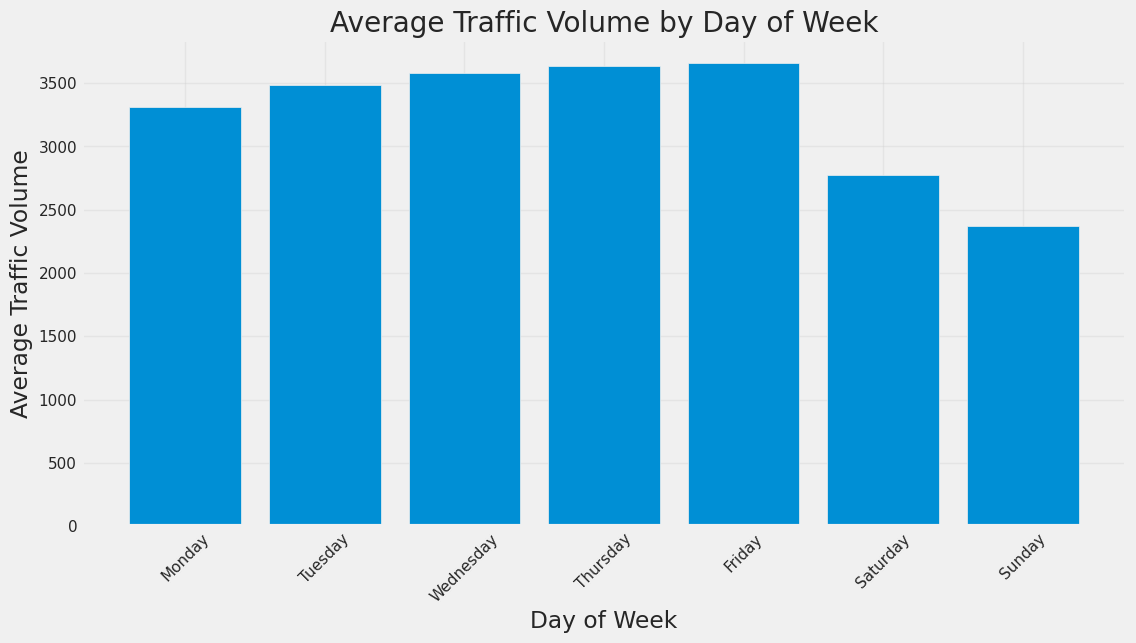

In [12]:
# Daily traffic patterns
daily_avg = data.groupby('day_of_week')['traffic_volume'].mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
plt.bar(days, daily_avg.values)
plt.title('Average Traffic Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Traffic Volume')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

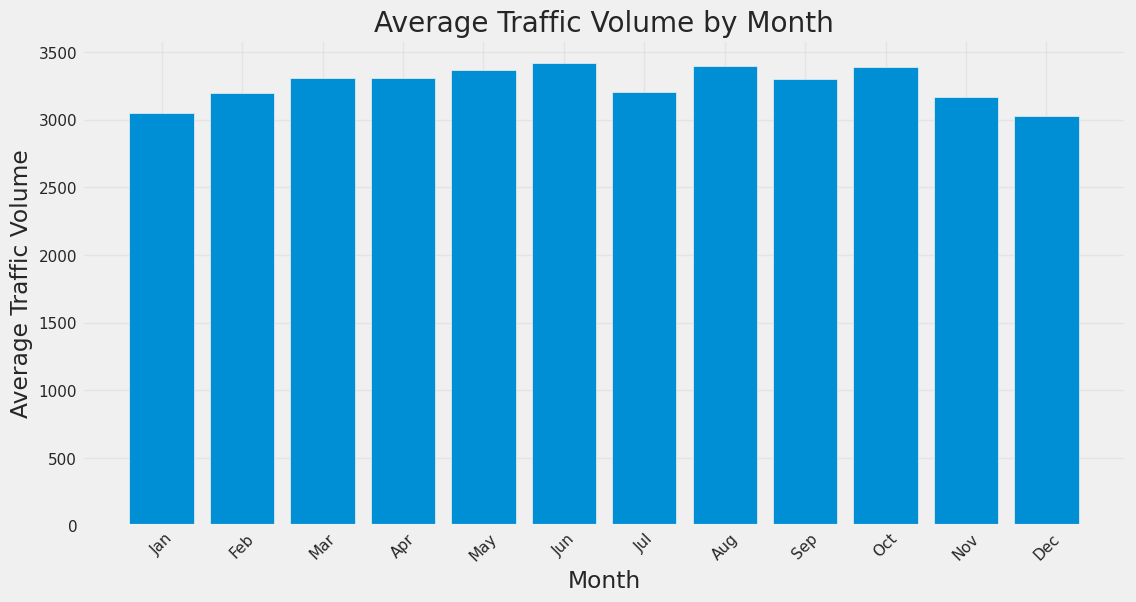

In [13]:
# Monthly traffic patterns
monthly_avg = data.groupby('month')['traffic_volume'].mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(12, 6))
plt.bar(months, monthly_avg.values)
plt.title('Average Traffic Volume by Month')
plt.xlabel('Month')
plt.ylabel('Average Traffic Volume')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

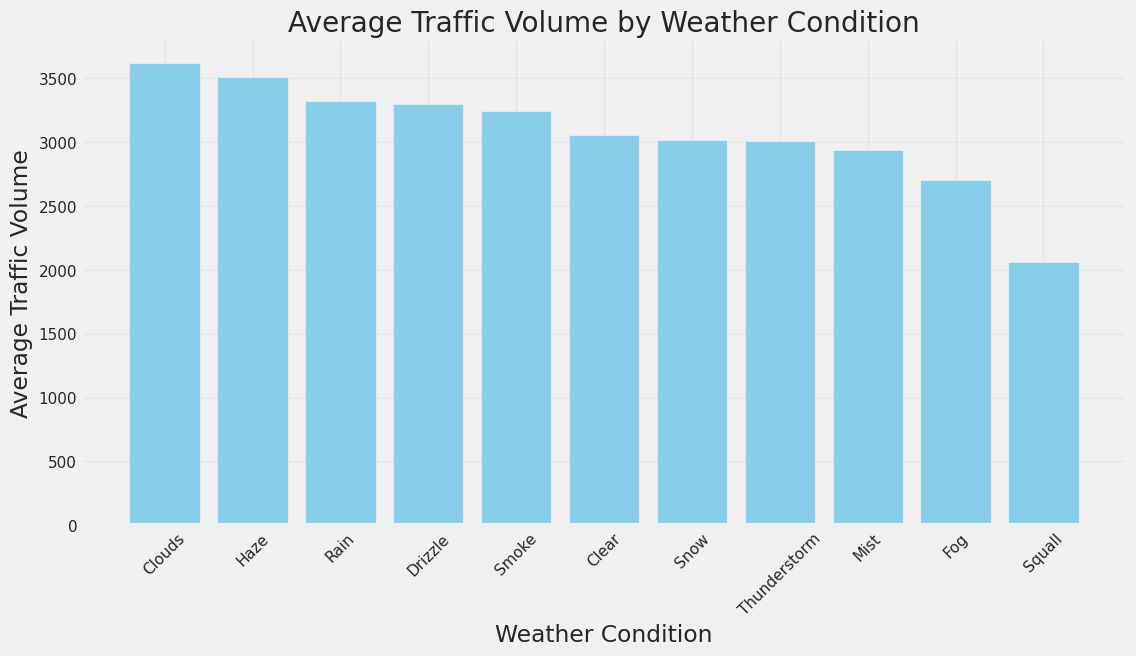

In [14]:
# Effect of weather conditions
weather_avg = data.groupby('weather_main')['traffic_volume'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(weather_avg.index, weather_avg.values, color='skyblue')
plt.title('Average Traffic Volume by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Average Traffic Volume')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

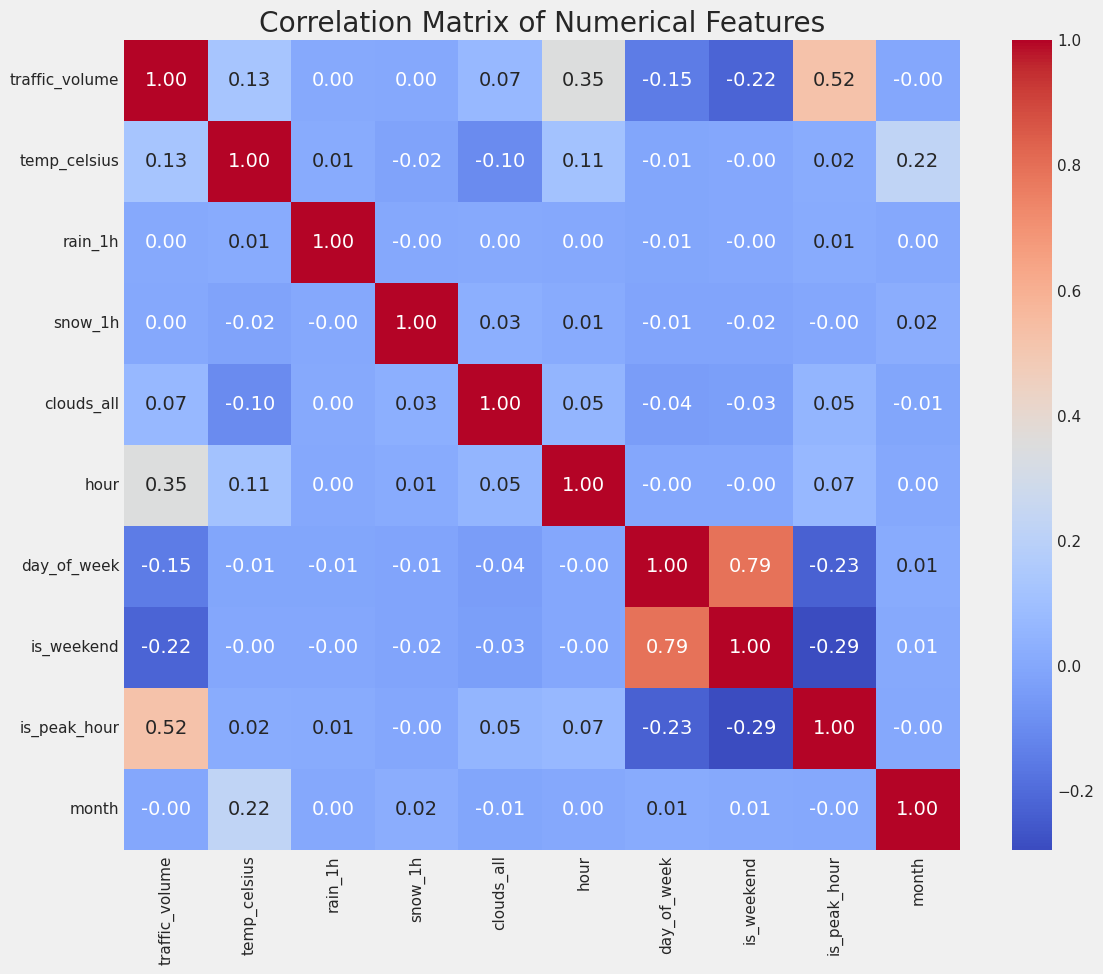

In [15]:
# Correlation matrix of numerical features
numerical_data = data[['traffic_volume', 'temp_celsius', 'rain_1h', 'snow_1h',
                       'clouds_all', 'hour', 'day_of_week', 'is_weekend',
                       'is_peak_hour', 'month']]

plt.figure(figsize=(12, 10))
corr_matrix = numerical_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## 4. Time Series Analysis

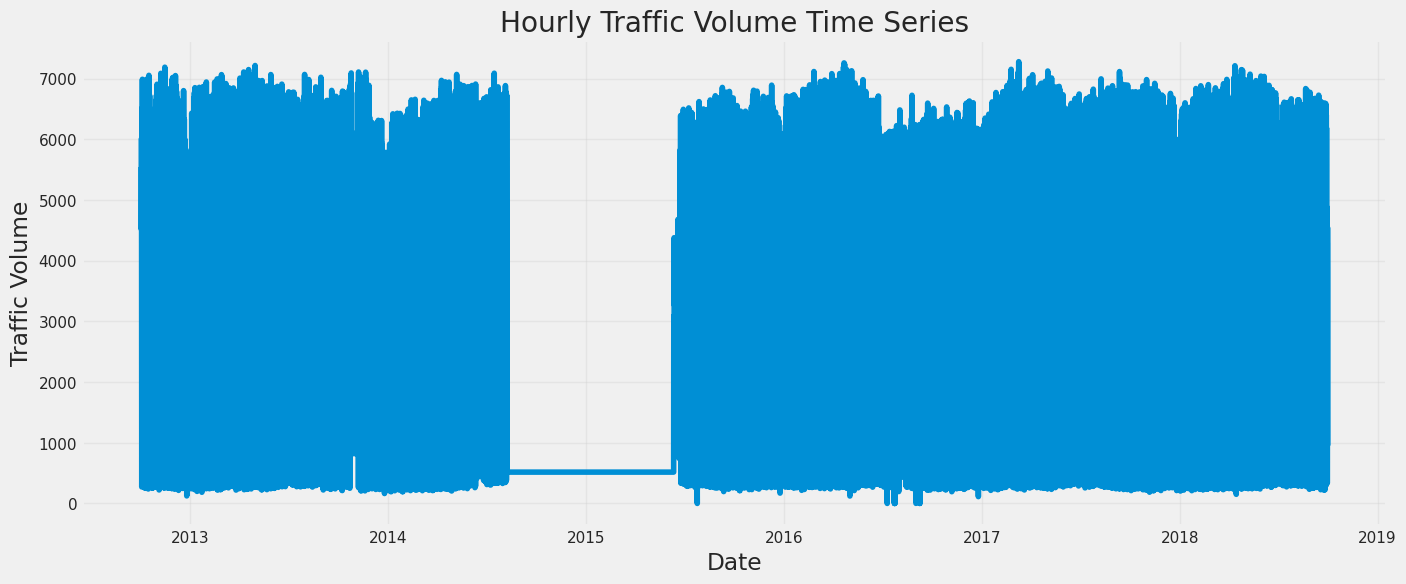

In [16]:
# Plot the time series
plt.figure(figsize=(15, 6))
plt.plot(data_hourly.index, data_hourly.values)
plt.title('Hourly Traffic Volume Time Series')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
# Stationarity test (Augmented Dickey-Fuller test)
result = adfuller(data_hourly.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result[1] <= 0.05:
    print("\nResult: The time series is stationary (p-value <= 0.05)")
else:
    print("\nResult: The time series is non-stationary (p-value > 0.05)")
    print("Non-stationary series typically need differencing before applying ARIMA models.")

ADF Statistic: -11.929356
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567

Result: The time series is stationary (p-value <= 0.05)


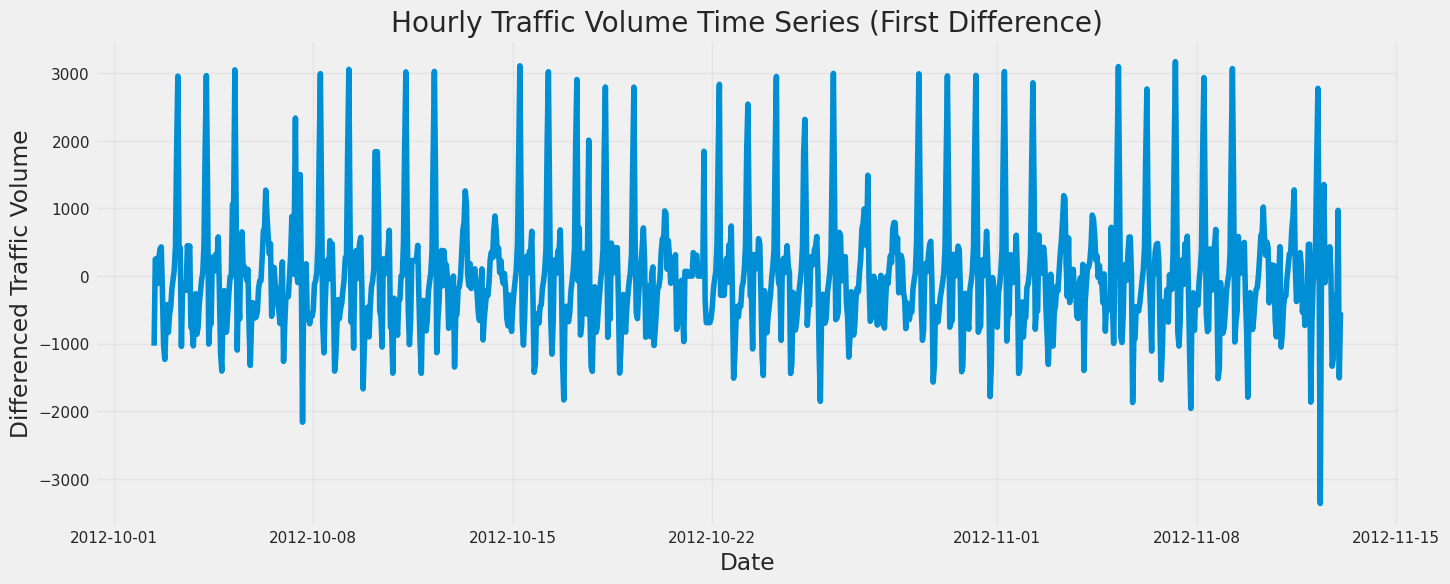

ADF Statistic: -37.685933
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567

Result: The differenced time series is stationary (p-value <= 0.05)


In [18]:
# Check if differencing helps with stationarity
data_hourly_diff = data_hourly.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(15, 6))
plt.plot(data_hourly_diff.index[:1000], data_hourly_diff.values[:1000])  # First 1000 points for better visibility
plt.title('Hourly Traffic Volume Time Series (First Difference)')
plt.xlabel('Date')
plt.ylabel('Differenced Traffic Volume')
plt.grid(True, alpha=0.3)
plt.show()

# Stationarity test on differenced series
result_diff = adfuller(data_hourly_diff.dropna())
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result_diff[1] <= 0.05:
    print("\nResult: The differenced time series is stationary (p-value <= 0.05)")
else:
    print("\nResult: The differenced time series is non-stationary (p-value > 0.05)")

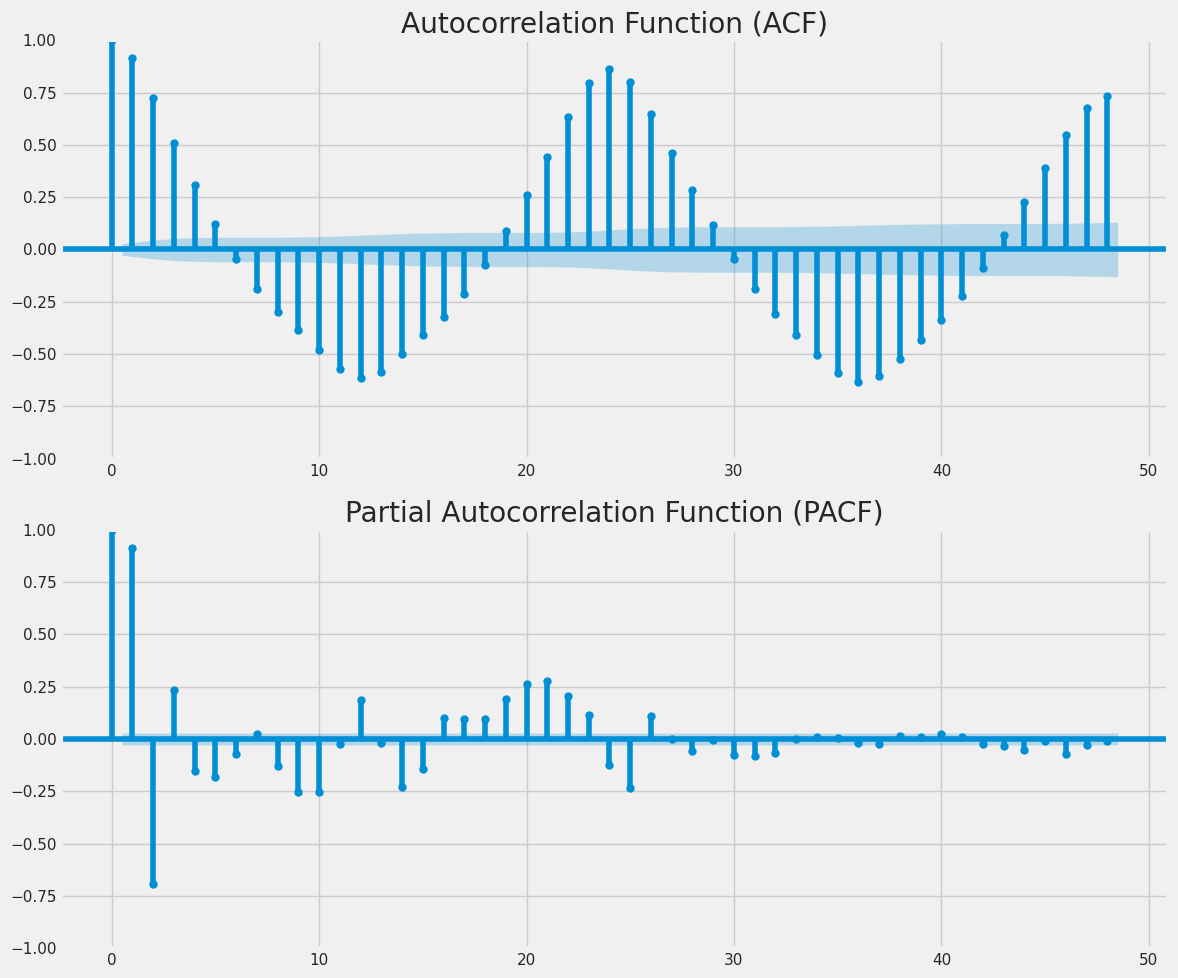

In [19]:
# ACF and PACF plots to identify potential AR and MA terms
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Sample size for ACF/PACF (limit to 5000 points for performance)
sample_size = min(len(data_hourly), 5000)
sample_data = data_hourly[-sample_size:]

# ACF plot
plot_acf(sample_data, lags=48, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(sample_data, lags=48, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### 4.1 Outlier Detection and Handling

Number of detected outliers: 0
Percentage of outliers: 0.00%


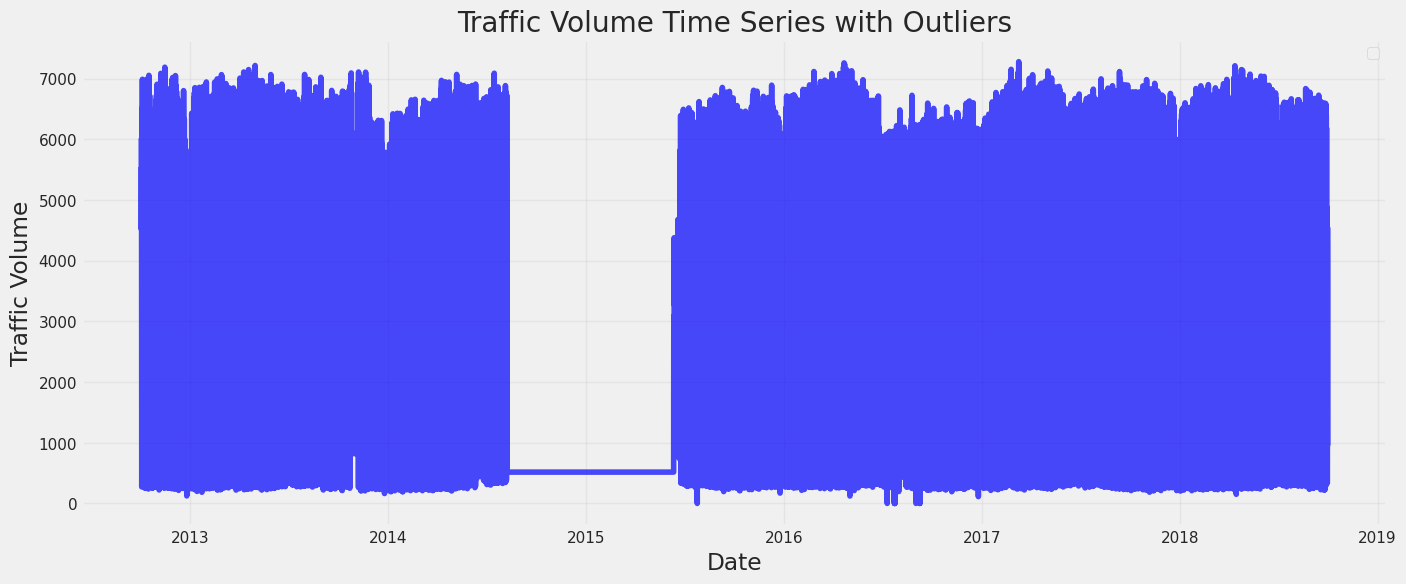

In [20]:
# Detect outliers using IQR method
Q1 = data_hourly.quantile(0.25)
Q3 = data_hourly.quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers = data_hourly[(data_hourly < lower_bound) | (data_hourly > upper_bound)]
print(f"Number of detected outliers: {len(outliers)}")
print(f"Percentage of outliers: {len(outliers) / len(data_hourly) * 100:.2f}%")

# Visualize outliers
plt.figure(figsize=(15, 6))
plt.plot(data_hourly.index, data_hourly.values, color='blue', alpha=0.7)
if len(outliers) > 0:
    plt.scatter(outliers.index, outliers.values, color='red', label='Outliers')
plt.title('Traffic Volume Time Series with Outliers')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
# Handle outliers
if len(outliers) > 0:
    # Strategy: Capping outliers at bounds rather than removing them (preserves time series integrity)
    data_hourly_cleaned = data_hourly.copy()
    data_hourly_cleaned[data_hourly_cleaned < lower_bound] = lower_bound
    data_hourly_cleaned[data_hourly_cleaned > upper_bound] = upper_bound

    # Compare original and cleaned data
    plt.figure(figsize=(15, 6))
    plt.plot(data_hourly.index[:1000], data_hourly.values[:1000], label='Original Data', alpha=0.5)
    plt.plot(data_hourly_cleaned.index[:1000], data_hourly_cleaned.values[:1000], label='Cleaned Data', alpha=0.8)
    plt.title('Original vs. Cleaned Data (First 1000 points)')
    plt.xlabel('Date')
    plt.ylabel('Traffic Volume')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Use cleaned data for modeling
    data_hourly = data_hourly_cleaned
    print("Outliers handled by capping at IQR boundaries")
else:
    print("No outliers to handle")

No outliers to handle


## 5. Data Preparation for Modeling

In [22]:
# Split data into training and testing sets (80% train, 20% test)
split_point = int(len(data_hourly) * 0.8)
train_data = data_hourly[:split_point]
test_data = data_hourly[split_point:]

print(f"Training data size: {len(train_data)} hours")
print(f"Testing data size: {len(test_data)} hours")
print(f"Training period: {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing period: {test_data.index.min()} to {test_data.index.max()}")

Training data size: 42040 hours
Testing data size: 10511 hours
Training period: 2012-10-02 09:00:00 to 2017-07-20 00:00:00
Testing period: 2017-07-20 01:00:00 to 2018-09-30 23:00:00


In [23]:
# For visualization purposes, let's use a smaller forecast horizon
forecast_horizon = min(len(test_data), 168)  # One week (168 hours) or full test set if smaller
print(f"Using forecast horizon of {forecast_horizon} hours for model comparison")

Using forecast horizon of 168 hours for model comparison


## 6. Model 1: ARIMA (AutoRegressive Integrated Moving Average)

In [24]:
# Define ARIMA order (p, d, q) based on ACF/PACF analysis
# p: AR order, d: differencing, q: MA order
p, d, q = 1, 1, 1  # Example parameters, adjust based on analysis

# Train ARIMA model
print(f"Training ARIMA model with order=({p}, {d}, {q})...")
arima_model = ARIMA(train_data, order=(p, d, q))
arima_fit = arima_model.fit()

# Model summary
print(arima_fit.summary())

Training ARIMA model with order=(1, 1, 1)...
                               SARIMAX Results                                
Dep. Variable:         traffic_volume   No. Observations:                42040
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -327172.462
Date:                Fri, 02 May 2025   AIC                         654350.924
Time:                        08:16:49   BIC                         654376.863
Sample:                    10-02-2012   HQIC                        654359.115
                         - 07-20-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3534      0.005     64.318      0.000       0.343       0.364
ma.L1          0.3507      0.006     60.814      0.000       0.339       0.362
sigma2 

In [25]:
# Generate ARIMA forecasts for test period
arima_forecast = arima_fit.get_forecast(steps=forecast_horizon)
arima_forecast_values = arima_forecast.predicted_mean

# Convert to Series with the correct index
arima_forecast_series = pd.Series(arima_forecast_values.values, index=test_data.index[:forecast_horizon])

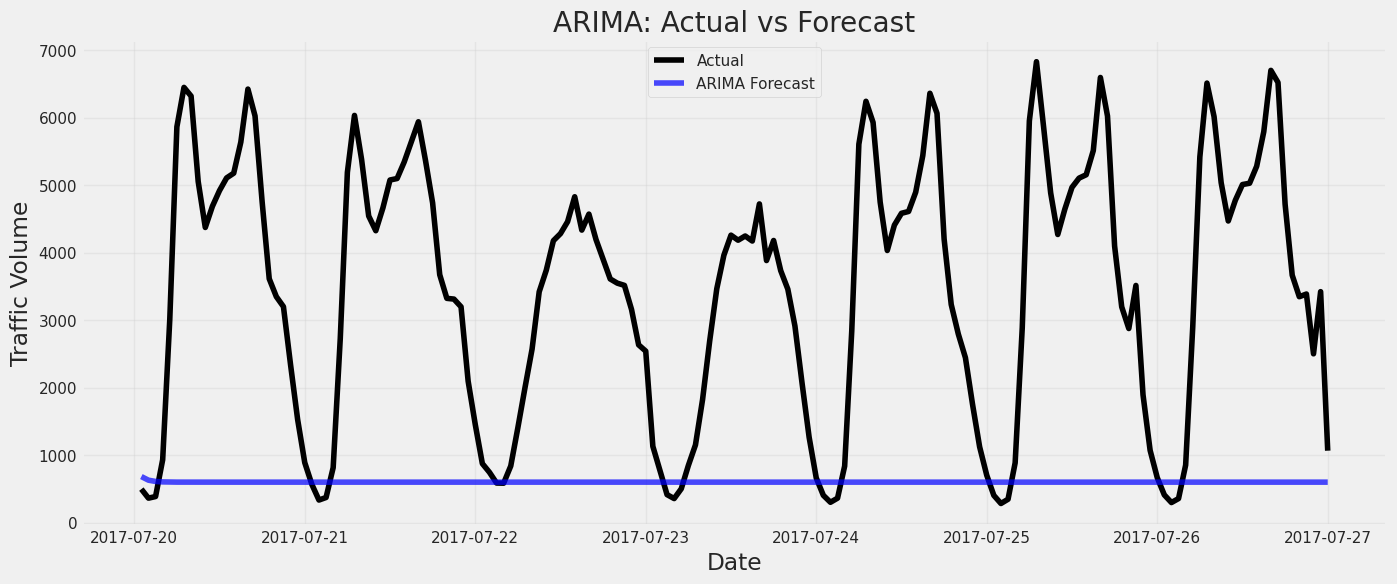

In [26]:
# Plot ARIMA forecasts vs actual values
plt.figure(figsize=(15, 6))
plt.plot(test_data.index[:forecast_horizon], test_data.values[:forecast_horizon], label='Actual', color='black')
plt.plot(arima_forecast_series.index, arima_forecast_series.values, label='ARIMA Forecast', color='blue', alpha=0.7)
plt.title('ARIMA: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Model 2: LSTM (Long Short-Term Memory Neural Network)

In [27]:
# Create sequences for LSTM model
def create_sequences(data, seq_length):
    """
    Create sequences for LSTM model
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [28]:
# Scale data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on training data
train_data_reshaped = train_data.values.reshape(-1, 1)
train_scaled = scaler.fit_transform(train_data_reshaped).flatten()

# Transform test data
test_data_reshaped = test_data.values.reshape(-1, 1)
test_scaled = scaler.transform(test_data_reshaped).flatten()

In [29]:
# Set sequence length (lookback window)
seq_length = 24  # 24 hours (1 day)

# Create sequences
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (42016, 24, 1)
y_train shape: (42016,)
X_test shape: (10487, 24, 1)
y_test shape: (10487,)


In [30]:
# Define LSTM model
tf.random.set_seed(42)  # For reproducibility
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))

# Compile model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0287 - val_loss: 0.0060
Epoch 2/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0067 - val_loss: 0.0030
Epoch 3/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 4/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 5/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 6/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 7/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 8/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 9/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 10/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 11/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 12/50
1313/131

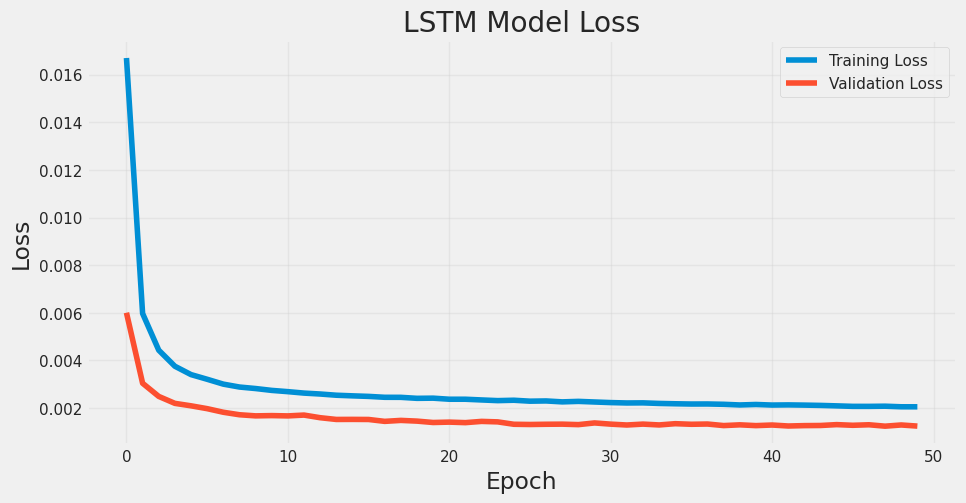

In [32]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [33]:
# Generate LSTM predictions
# We need to predict step-by-step for the test period
lstm_predictions = []

# Initial sequence from training data
curr_seq = train_scaled[-seq_length:].reshape(1, seq_length, 1)

# For each time step in test period (using forecast_horizon)
for i in range(forecast_horizon):
    # Make prediction
    pred = lstm_model.predict(curr_seq, verbose=0)[0, 0]
    lstm_predictions.append(pred)

    # Update sequence
    curr_seq = np.append(curr_seq[:, 1:, :], [[[pred]]], axis=1)

# Inverse transform predictions
lstm_predictions = np.array(lstm_predictions).reshape(-1, 1)
lstm_predictions = scaler.inverse_transform(lstm_predictions).flatten()

# Convert to Series with the correct index
lstm_forecast_series = pd.Series(lstm_predictions, index=test_data.index[:forecast_horizon])

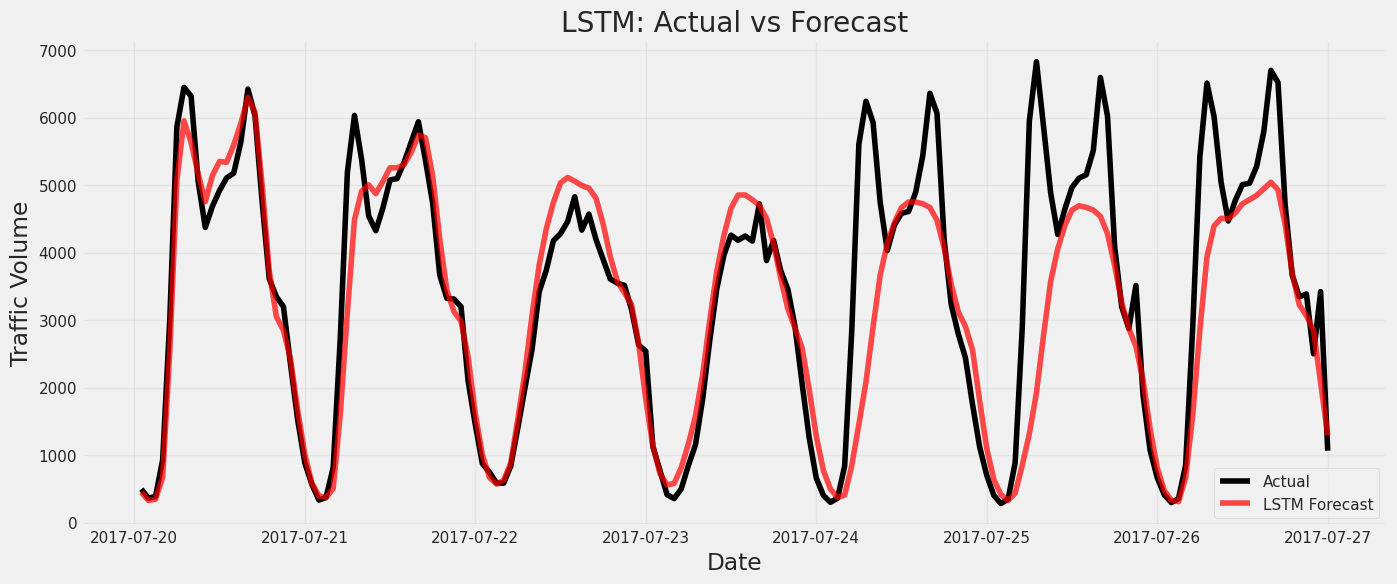

In [34]:
# Plot LSTM forecasts vs actual values
plt.figure(figsize=(15, 6))
plt.plot(test_data.index[:forecast_horizon], test_data.values[:forecast_horizon], label='Actual', color='black')
plt.plot(lstm_forecast_series.index, lstm_forecast_series.values, label='LSTM Forecast', color='red', alpha=0.7)
plt.title('LSTM: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. Model 3: Hybrid Model (ARIMA + LSTM)

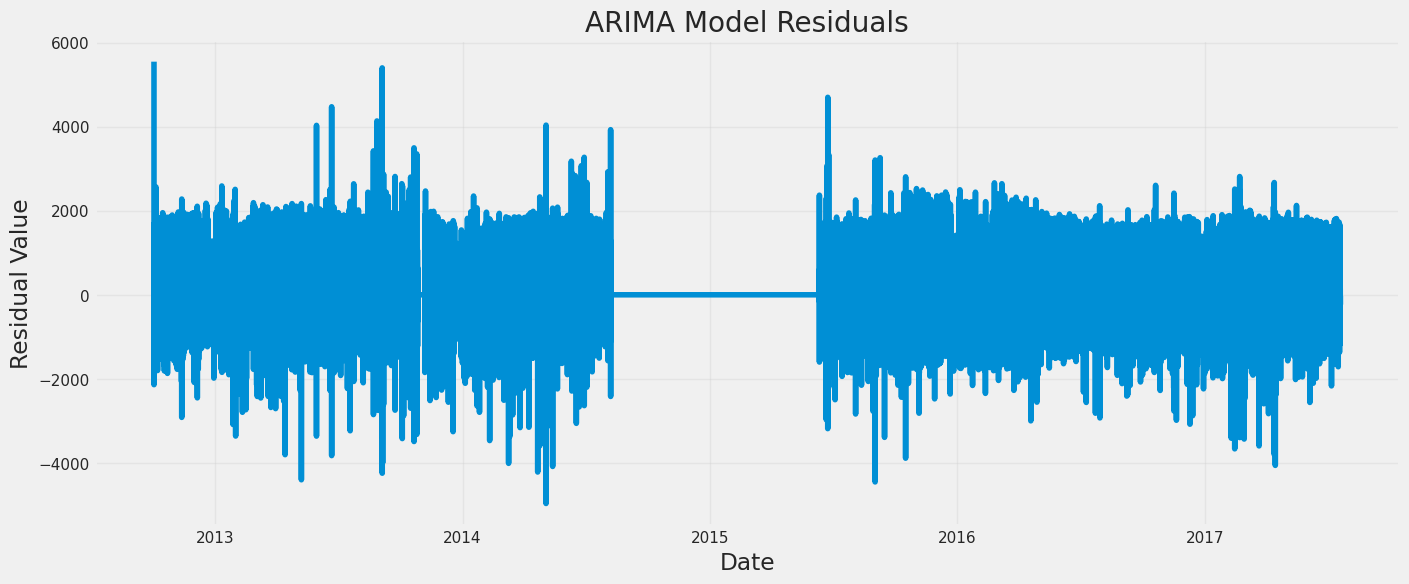

In [35]:
# Get ARIMA residuals
arima_in_sample_pred = arima_fit.fittedvalues
arima_residuals = train_data[len(train_data) - len(arima_in_sample_pred):] - arima_in_sample_pred

plt.figure(figsize=(15, 6))
plt.plot(arima_residuals.index, arima_residuals.values)
plt.title('ARIMA Model Residuals')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.grid(True, alpha=0.3)
plt.show()

In [36]:
# Scale residuals
residuals_scaler = MinMaxScaler(feature_range=(0, 1))
residuals_reshaped = arima_residuals.values.reshape(-1, 1)
residuals_scaled = residuals_scaler.fit_transform(residuals_reshaped).flatten()

In [37]:
# Create sequences for LSTM
X_residuals, y_residuals = create_sequences(residuals_scaled, seq_length)
X_residuals = X_residuals.reshape(X_residuals.shape[0], X_residuals.shape[1], 1)

print(f"X_residuals shape: {X_residuals.shape}")
print(f"y_residuals shape: {y_residuals.shape}")

X_residuals shape: (42016, 24, 1)
y_residuals shape: (42016,)


In [38]:
# Define LSTM model for residuals
tf.random.set_seed(42)  # For reproducibility
residual_lstm_model = Sequential()
residual_lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
residual_lstm_model.add(Dropout(0.2))
residual_lstm_model.add(LSTM(units=50))
residual_lstm_model.add(Dropout(0.2))
residual_lstm_model.add(Dense(units=1))

# Compile model
residual_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
residual_lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Train model
residual_history = residual_lstm_model.fit(
    X_residuals, y_residuals,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0098 - val_loss: 0.0041
Epoch 2/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 3/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 4/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 5/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 6/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 7/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 8/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 9/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 10/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 11/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 12/50
1051/10

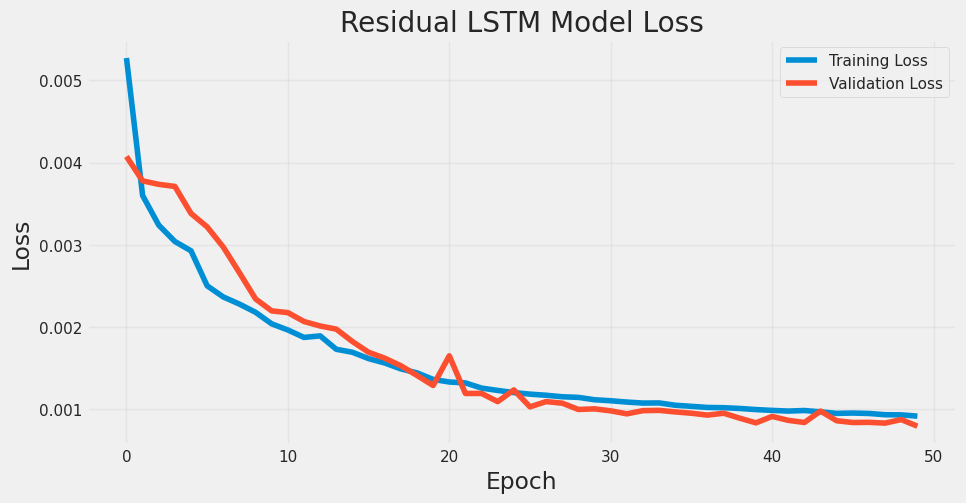

In [40]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(residual_history.history['loss'], label='Training Loss')
plt.plot(residual_history.history['val_loss'], label='Validation Loss')
plt.title('Residual LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [41]:
# Generate residual predictions
residual_predictions = []

# Initial sequence from residuals
curr_residual_seq = residuals_scaled[-seq_length:].reshape(1, seq_length, 1)

# For each time step in the test period
for i in range(forecast_horizon):
    # Make prediction
    pred = residual_lstm_model.predict(curr_residual_seq, verbose=0)[0, 0]
    residual_predictions.append(pred)

    # Update sequence
    curr_residual_seq = np.append(curr_residual_seq[:, 1:, :], [[[pred]]], axis=1)

# Inverse transform predictions
residual_predictions = np.array(residual_predictions).reshape(-1, 1)
residual_predictions = residuals_scaler.inverse_transform(residual_predictions).flatten()

# Convert to Series with the correct index
residual_forecast_series = pd.Series(residual_predictions, index=test_data.index[:forecast_horizon])

In [42]:
# Combine ARIMA forecasts and LSTM residual forecasts for hybrid model
hybrid_forecast_series = arima_forecast_series + residual_forecast_series

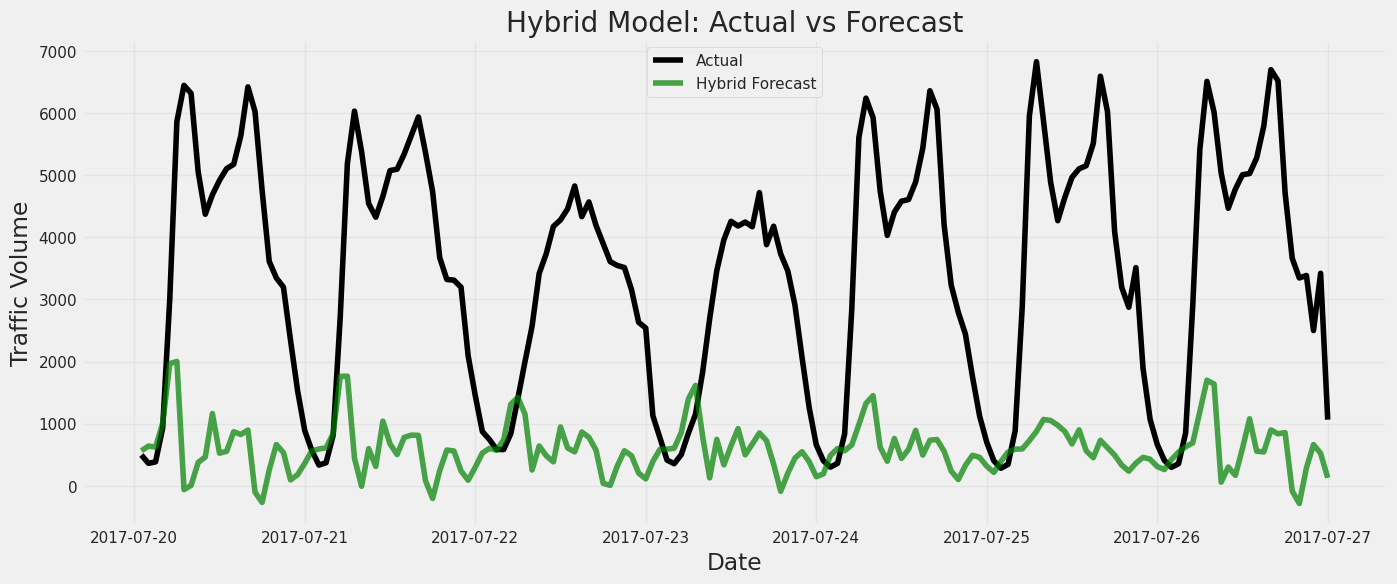

In [43]:
# Plot hybrid model forecasts vs actual values
plt.figure(figsize=(15, 6))
plt.plot(test_data.index[:forecast_horizon], test_data.values[:forecast_horizon], label='Actual', color='black')
plt.plot(hybrid_forecast_series.index, hybrid_forecast_series.values, label='Hybrid Forecast', color='green', alpha=0.7)
plt.title('Hybrid Model: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. Model Comparison and Evaluation

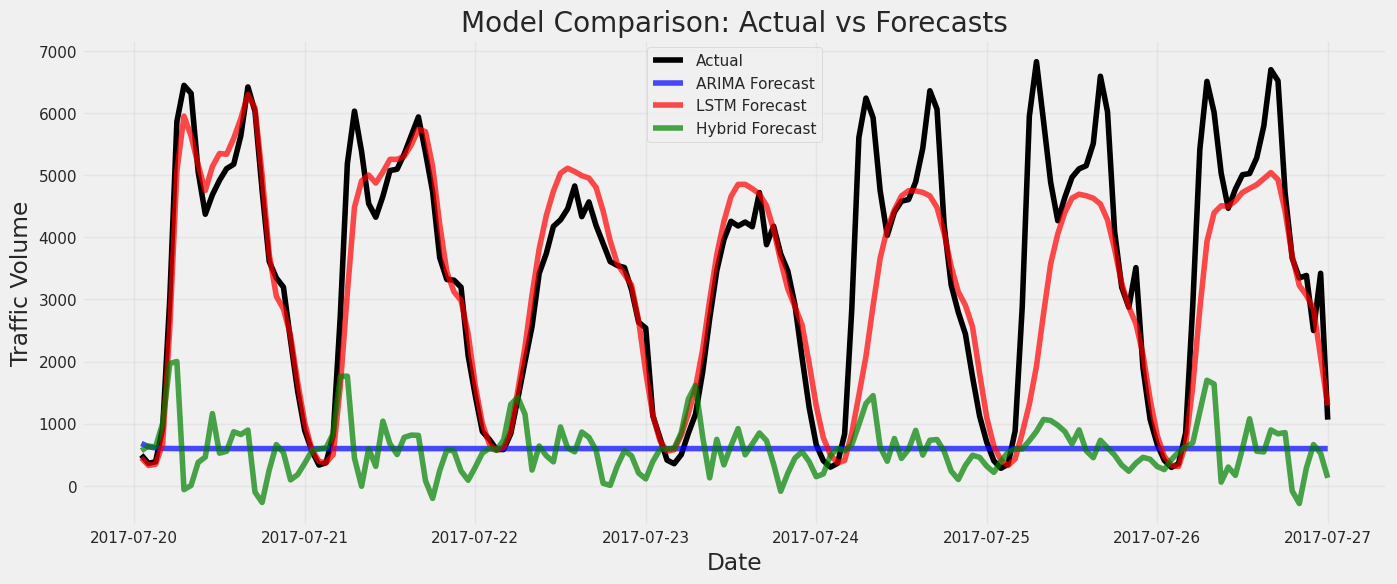

In [44]:
# Plot all models together
plt.figure(figsize=(15, 6))
plt.plot(test_data.index[:forecast_horizon], test_data.values[:forecast_horizon], label='Actual', color='black')
plt.plot(arima_forecast_series.index, arima_forecast_series.values, label='ARIMA Forecast', color='blue', alpha=0.7)
plt.plot(lstm_forecast_series.index, lstm_forecast_series.values, label='LSTM Forecast', color='red', alpha=0.7)
plt.plot(hybrid_forecast_series.index, hybrid_forecast_series.values, label='Hybrid Forecast', color='green', alpha=0.7)
plt.title('Model Comparison: Actual vs Forecasts')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [45]:
# Calculate evaluation metrics
def calculate_metrics(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)

    return pd.DataFrame({
        'Model': [model_name],
        'MAE': [mae],
        'RMSE': [rmse],
        'R²': [r2]
    })

# Get evaluation results for each model
arima_metrics = calculate_metrics(
    test_data[:len(arima_forecast_series)],
    arima_forecast_series,
    'ARIMA'
)

lstm_metrics = calculate_metrics(
    test_data[:len(lstm_forecast_series)],
    lstm_forecast_series,
    'LSTM'
)

hybrid_metrics = calculate_metrics(
    test_data[:len(hybrid_forecast_series)],
    hybrid_forecast_series,
    'Hybrid'
)

# Combine results
evaluation_results = pd.concat([arima_metrics, lstm_metrics, hybrid_metrics], ignore_index=True)
evaluation_results

,Model,MAE,RMSE,R²
0,ARIMA,2880.023181,3428.021355,-2.156025
1,LSTM,580.952172,1020.394401,0.720366
2,Hybrid,2893.968839,3419.906823,-2.141101


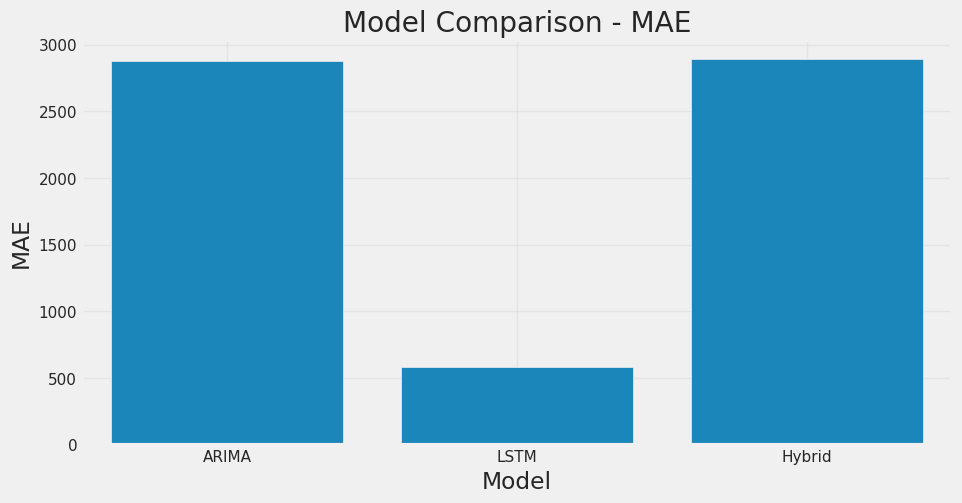

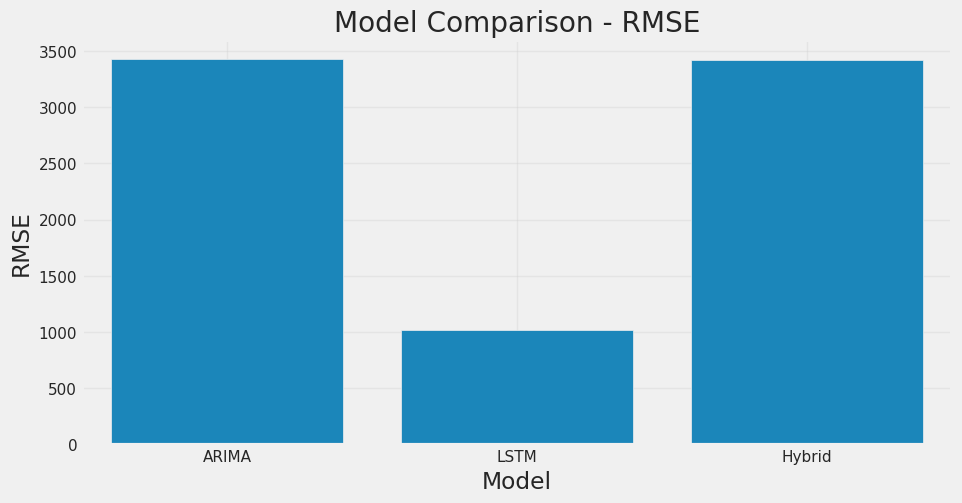

In [46]:
# Visualize evaluation metrics
metrics = ['MAE', 'RMSE']
for metric in metrics:
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Model', y=metric, data=evaluation_results)
    plt.title(f'Model Comparison - {metric}')
    plt.ylabel(metric)
    plt.grid(True, alpha=0.3)
    plt.show()

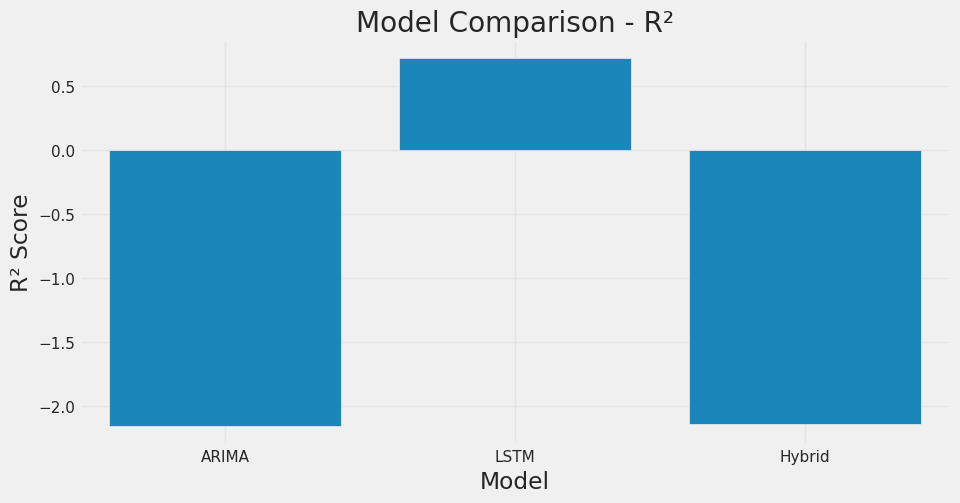

In [47]:
# Visualize R² metric
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='R²', data=evaluation_results)
plt.title('Model Comparison - R²')
plt.ylabel('R² Score')
plt.grid(True, alpha=0.3)
plt.show()